#시간대별 발생 패턴 기반 유사군 분류(clustering)

In [1]:
# 1. 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
#. 나눔고딕 폰트 설치 (한글 폰트용)
!apt-get -qq install -y fonts-nanum
import matplotlib.pyplot as plt


Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
import matplotlib.font_manager as fm
# 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

In [4]:
plt.rc('font', family='NanumGothic')  # 전역 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

In [5]:
# 2. 데이터 로드
df = pd.read_csv("전처리_시간대별_강력범죄_및_인구환경데이터.csv")

In [6]:
# 3. 사용할 범죄유형 컬럼 정의
crime_columns = [
    '살인기수', '살인미수등', '강도', '강간', '유사강간', '강제추행',
    '기타 강간 강제추행등', '방화', '상해', '폭행', '체포 감금',
    '협박', '약취 유인', '폭력행위등', '공갈'
]

In [7]:
# 4. 데이터 전처리: long → wide 형태로
df_melted = df[['시간대'] + crime_columns].melt(id_vars='시간대', var_name='범죄유형', value_name='발생건수')
pivot_df = df_melted.pivot_table(index='범죄유형', columns='시간대', values='발생건수').fillna(0)


In [8]:
# 5. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_df)


적절한 K 도출

In [9]:
inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

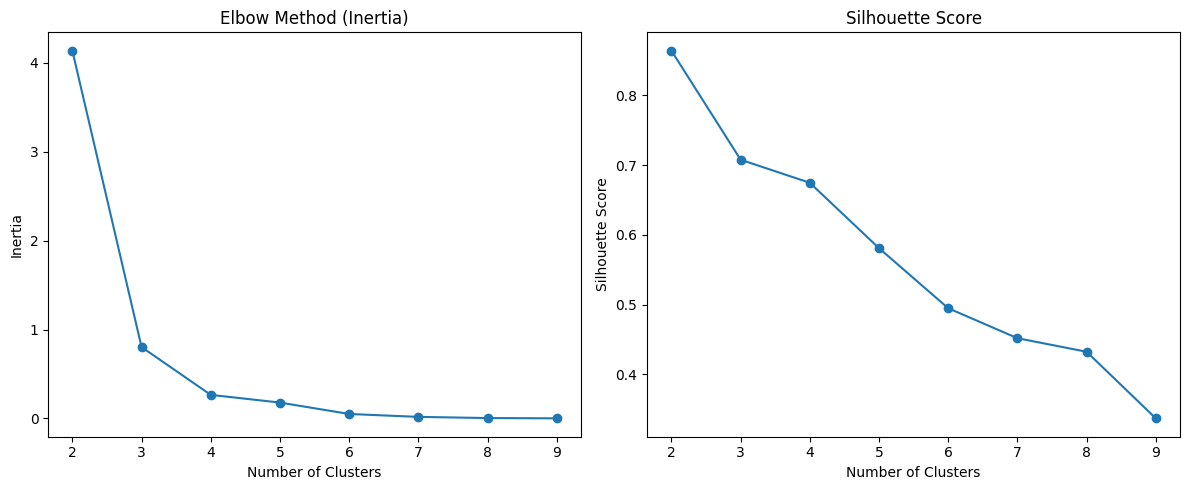

In [10]:
# k 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

#[1] K-means Clustering

In [11]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pivot_df['KMeans_클러스터'] = kmeans.fit_predict(X_scaled)


In [12]:
pivot_df[['KMeans_클러스터']]

시간대,KMeans_클러스터
범죄유형,
강간,0
강도,0
강제추행,2
공갈,0
기타 강간 강제추행등,0
방화,0
살인기수,0
살인미수등,0
상해,2


In [13]:
# 클러스터별로 어떤 범죄유형들이 속했는지 확인
for cluster_num in sorted(pivot_df['KMeans_클러스터'].unique()):
    print(f"\n🟢 클러스터 {cluster_num} 에 속한 범죄유형:")
    print(pivot_df[pivot_df['KMeans_클러스터'] == cluster_num].index.tolist())


🟢 클러스터 0 에 속한 범죄유형:
['강간', '강도', '공갈', '기타 강간 강제추행등', '방화', '살인기수', '살인미수등', '약취 유인', '유사강간', '체포 감금', '폭력행위등']

🟢 클러스터 1 에 속한 범죄유형:
['폭행']

🟢 클러스터 2 에 속한 범죄유형:
['강제추행', '상해', '협박']


클러스터별 평균 시간대 분포 비교(시각화)

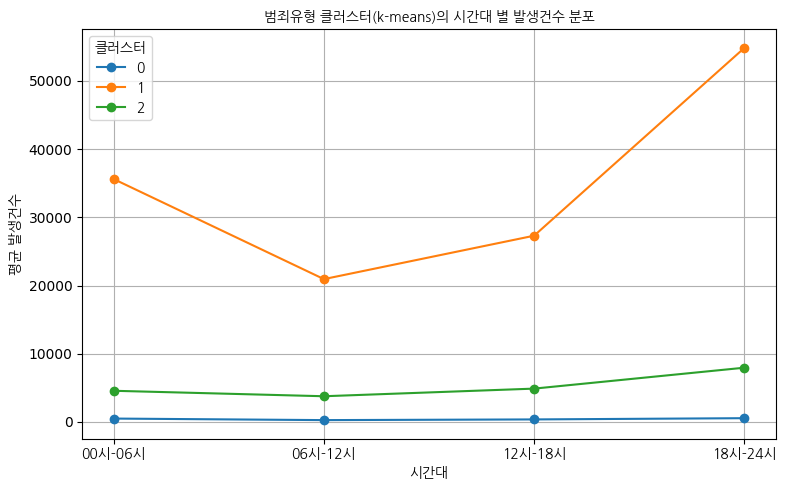

In [23]:
# 시각화를 위해 클러스터 컬럼 제외한 부분만 선택
clustered_means = pivot_df.groupby('KMeans_클러스터').mean().drop(columns=['KMeans_클러스터'], errors='ignore')

# 꺾은선 그래프로 평균 분포 비교
clustered_means.T.plot(kind='line', marker='o', figsize=(8, 5))
plt.title("범죄유형 클러스터(k-means)의 시간대 별 발생건수 분포", fontproperties=font_prop)
plt.xlabel("시간대", fontproperties=font_prop)
plt.ylabel("평균 발생건수", fontproperties=font_prop)

# ✅ x축 라벨 수동 설정
plt.xticks(ticks=range(len(clustered_means.T.index)),
           labels=clustered_means.T.index.tolist(),
           fontproperties=font_prop)

plt.legend(title='클러스터', prop=font_prop, title_fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

#[2] Hierarchical Clustering

In [17]:
linked = linkage(X_scaled, method='ward')
#X_scaled는 pivot_df의 Z-score 정규화된 값
#method='ward'는 군집 간 분산 증가 최소화를 기준으로 군집을 병합

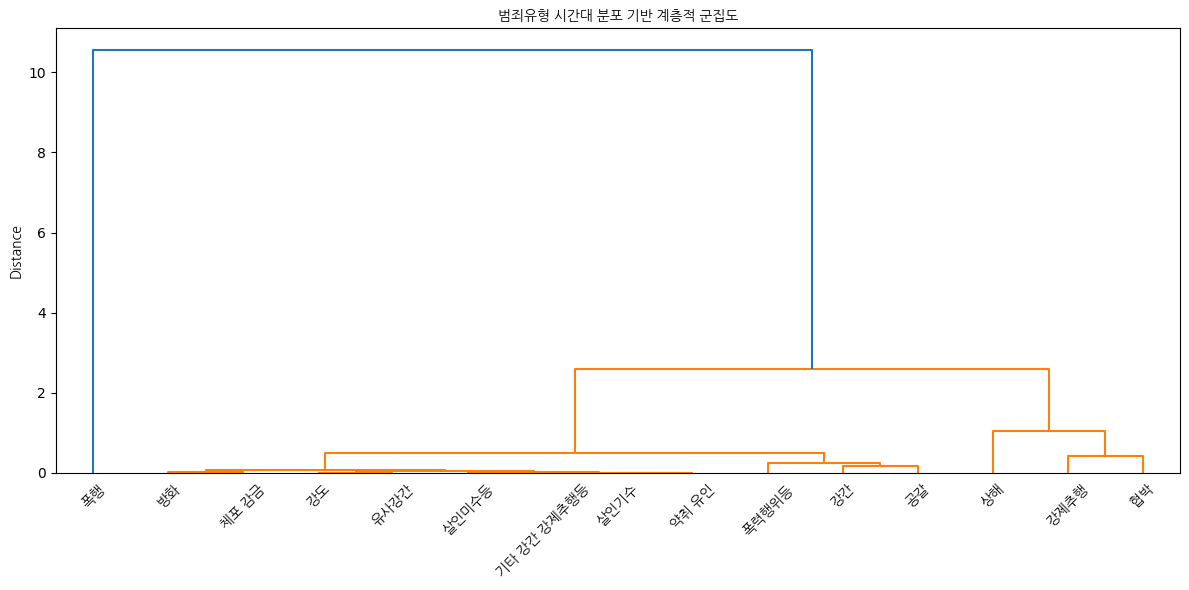

In [24]:
# 덴드로그램 시각화
plt.figure(figsize=(12, 6))
dendro = dendrogram(
    linked,
    labels=pivot_df.index.tolist(),     # pivot_df = 각 범죄유형(행)에 대한 시간대별 발생건수 벡터(4차원 벡터)
    leaf_rotation=45
)

#-> 시간대별 발생 분포가 유사한 범죄유형들끼리 가까운 거리로 묶고,
#->이 유사도를 바탕으로 병합 과정을 그린 것이 **덴드로그램(dendrogram)**


# 제목, y축 라벨
plt.title("범죄유형 시간대 분포 기반 계층적 군집도", fontproperties=font_prop)
plt.ylabel("Distance", fontproperties=font_prop)

# ✅ x축 라벨 (한글 깨짐 방지용 수동 적용)
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)

plt.tight_layout()
plt.show()

#계층적 군집에서 fcluster로 군집 나누기
- 폭행이 매우 높은 거리에서 다른 군집과 합쳐지고
- 그 외 나머지는 하단에서 여러 번 짧게 병합됨
- => 이 경우 ***거리 기준***으로 자르는 방식이 패턴 보존에 더 적합

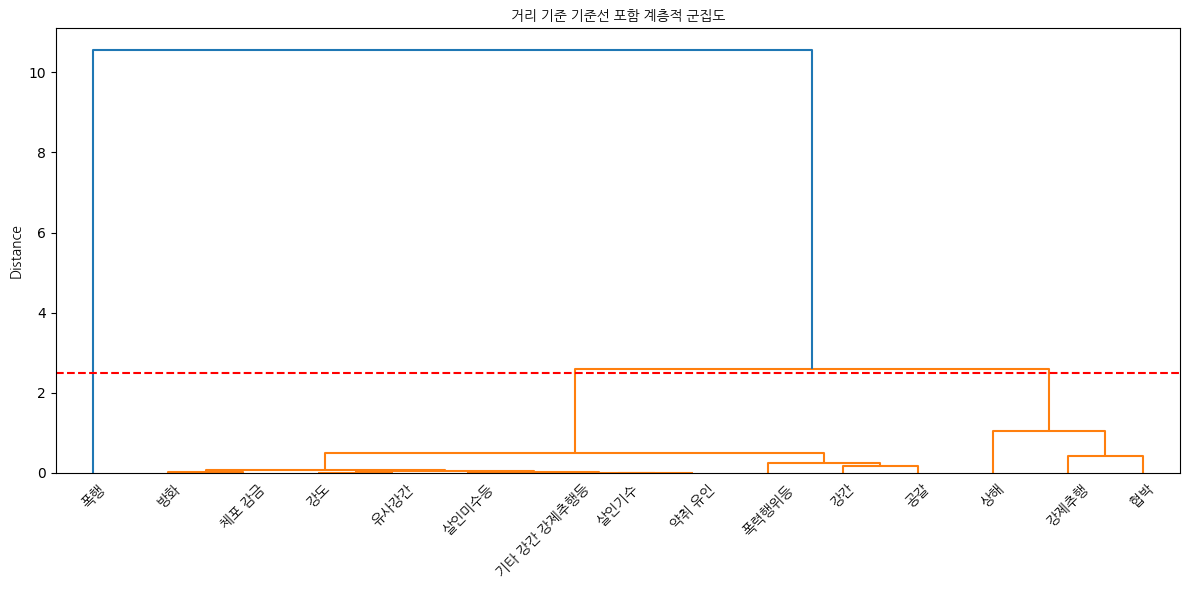

In [31]:
#시각적으로 자를 위치 판단
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=pivot_df.index.tolist(), leaf_rotation=45)
plt.axhline(y=threshold, color='red', linestyle='--')  # 자를 거리 기준 시각화
plt.title("거리 기준 기준선 포함 계층적 군집도", fontproperties=font_prop)
plt.ylabel("Distance", fontproperties=font_prop)

ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)

plt.tight_layout()
plt.show()


In [32]:
from scipy.cluster.hierarchy import fcluster

# 거리 기준으로 자르기 (예: y=4.0 선 기준)
threshold = 2.5
cluster_labels = fcluster(linked, t=threshold, criterion='distance')

# 결과 저장
pivot_df['Hierarchical_클러스터'] = cluster_labels

# 클러스터별 구성 확인
for c in sorted(set(cluster_labels)):
    print(f"\n[클러스터 {c}]")
    print(pivot_df[pivot_df['Hierarchical_클러스터'] == c].index.tolist())



[클러스터 1]
['강간', '강도', '공갈', '기타 강간 강제추행등', '방화', '살인기수', '살인미수등', '약취 유인', '유사강간', '체포 감금', '폭력행위등']

[클러스터 2]
['강제추행', '상해', '협박']

[클러스터 3]
['폭행']


In [33]:
# 두 방법의 군집 결과를 병합 비교
comparison = pivot_df[['KMeans_클러스터', 'Hierarchical_클러스터']]
print(comparison.sort_values(by='KMeans_클러스터'))

#동일하게 구분됨

시간대          KMeans_클러스터  Hierarchical_클러스터
범죄유형                                       
강간                     0                  1
강도                     0                  1
공갈                     0                  1
기타 강간 강제추행등            0                  1
살인기수                   0                  1
방화                     0                  1
살인미수등                  0                  1
약취 유인                  0                  1
체포 감금                  0                  1
유사강간                   0                  1
폭력행위등                  0                  1
폭행                     1                  3
강제추행                   2                  2
상해                     2                  2
협박                     2                  2


In [106]:
# 1. 필수 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.decomposition import PCA

# 한글 폰트
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)


In [107]:
# 2. PCA 수행 (X_scaled는 클러스터링에 사용한 표준화된 데이터)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [108]:
# 4. 결과 DataFrame 구성
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=pivot_df.index)
pca_df['KMeans_클러스터'] = pivot_df['KMeans_클러스터'].astype(int)
pca_df['Hierarchical_클러스터'] = pivot_df['Hierarchical_클러스터'].astype(int)
pca_df['범죄유형'] = pivot_df.index

In [109]:
pca_df[['PC1', 'PC2', 'KMeans_클러스터', 'Hierarchical_클러스터']].head()


,PC1,PC2,KMeans_클러스터,Hierarchical_클러스터
범죄유형,,,,
강간,-0.625275,0.075193,0,1
강도,-0.828595,0.035799,0,1
강제추행,-0.007171,0.003334,2,2
공갈,-0.691935,-0.047660,0,1
기타 강간 강제추행등,-0.854067,0.032199,0,1


In [111]:
!pip install adjustText

<ipython-input-112-a7f6251abebd>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pca_df['PC1'][i],
<ipython-input-112-a7f6251abebd>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pca_df['PC2'][i],
<ipython-input-112-a7f6251abebd>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pca_df['범죄유형'][i],
/usr/local/lib/python3.11/dist-packages/adjustText/__init__.py:419: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from

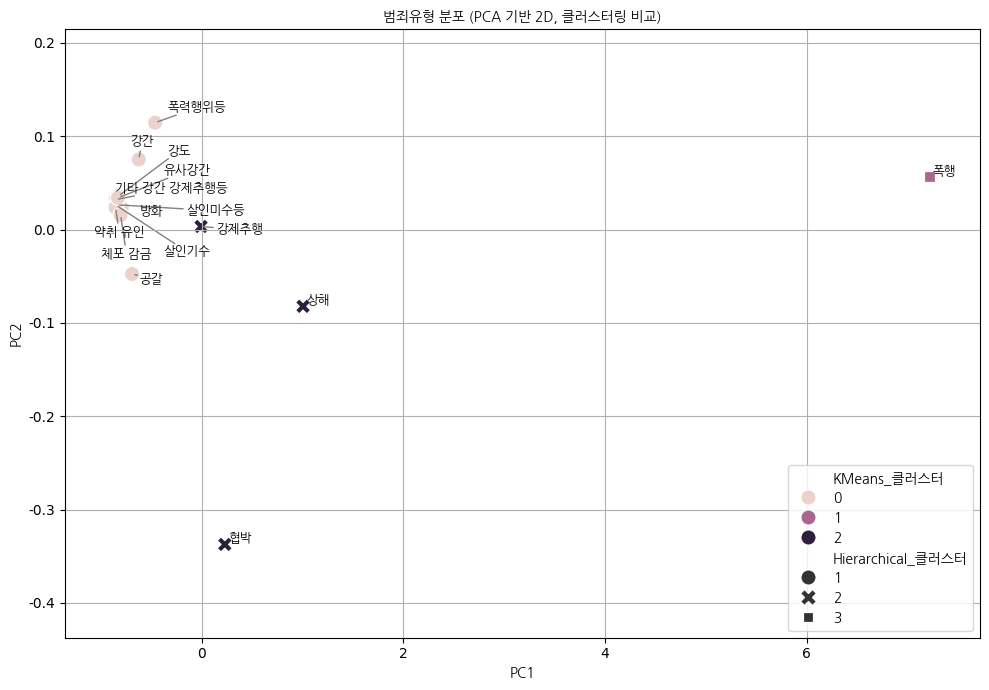

In [112]:
from adjustText import adjust_text

plt.figure(figsize=(10, 7))

# 1. 산점도 (s 크기 줄임)
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='KMeans_클러스터',
    style='Hierarchical_클러스터',
    s=120  # ✅ 도형 크기 축소
)

# 2. 축 범위
plt.xlim(pca_df['PC1'].min() - 0.5, pca_df['PC1'].max() + 0.5)
plt.ylim(pca_df['PC2'].min() - 0.1, pca_df['PC2'].max() + 0.1)

# 3. 텍스트 라벨 (위치 자동 조정 위해 adjust_text 사용)
texts = []
for i in range(len(pca_df)):
    texts.append(
        plt.text(
            pca_df['PC1'][i],
            pca_df['PC2'][i],
            pca_df['범죄유형'][i],
            fontproperties=font_prop,
            fontsize=9
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

# 4. 제목 및 축
plt.title("범죄유형 분포 (PCA 기반 2D, 클러스터링 비교)", fontproperties=font_prop)
plt.xlabel("PC1", fontproperties=font_prop)
plt.ylabel("PC2", fontproperties=font_prop)

# 5. 범례 폰트 적용
legend = plt.legend()
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
legend.get_title().set_fontproperties(font_prop)

plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
pca_df.info()
pca_df[['PC1', 'PC2', 'KMeans_클러스터', 'Hierarchical_클러스터']].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 강간 to 협박
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PC1                15 non-null     float64
 1   PC2                15 non-null     float64
 2   KMeans_클러스터        15 non-null     int64  
 3   Hierarchical_클러스터  15 non-null     int64  
 4   범죄유형               15 non-null     object 
dtypes: float64(2), int64(2), object(1)
memory usage: 1.2+ KB


,PC1,PC2,KMeans_클러스터,Hierarchical_클러스터
범죄유형,,,,
강간,-0.625275,0.075193,0,1
강도,-0.828595,0.035799,0,1
강제추행,-0.007171,0.003334,2,2
공갈,-0.691935,-0.047660,0,1
기타 강간 강제추행등,-0.854067,0.032199,0,1
방화,-0.794125,0.023070,0,1
살인기수,-0.853930,0.026436,0,1
살인미수등,-0.844187,0.026624,0,1
상해,1.004757,-0.082221,2,2


In [57]:
pca_df.head()

,PC1,PC2,KMeans_클러스터,Hierarchical_클러스터,범죄유형
범죄유형,,,,,
강간,-0.625275,0.075193,0,1,강간
강도,-0.828595,0.035799,0,1,강도
강제추행,-0.007171,0.003334,2,2,강제추행
공갈,-0.691935,-0.047660,0,1,공갈
기타 강간 강제추행등,-0.854067,0.032199,0,1,기타 강간 강제추행등
